Some reference here:
https://www.kaggle.com/yufengdev/bbc-text-categorization/notebook

In [1]:
import pandas as pd

In [2]:
bbc_articles = pd.read_csv("data/bbc-text.csv")

In [3]:
bbc_articles.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
bbc_articles['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

##### Tokenization for multiple purposes

In [5]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
import string

In [6]:
# Fill any blank fields
bbc_articles.category.fillna("", inplace=True)

all_text = bbc_articles.text

words = nltk.word_tokenize(" ".join(all_text.tolist()))

nltk_stopwords = stopwords.words('english') 
unigrams = [i for i in words if i not in nltk_stopwords and i.isalpha() and len(i) > 2]

##### NLTK is not always the best choice though!

##### You can try Spacy next time.

In [7]:
len(unigrams)

458124

##### Wordcloud on unigrams

In [8]:
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

wordcloud2 = WordCloud(
                stopwords=STOPWORDS,
                background_color='white',
                width=2000,
                height=1000
            ).generate(" ".join(unigrams))

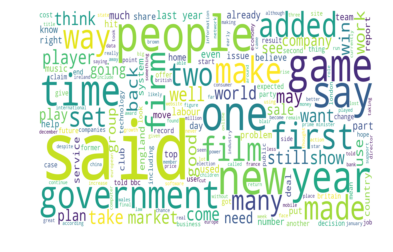

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(wordcloud2, interpolation="bilinear", aspect='auto')
plt.axis('off')
plt.show()

##### Can we learn more from bigrams and trigrams?

In [10]:
bigrams = nltk.bigrams(unigrams)
trigrams = nltk.trigrams(unigrams)

# look at the most common. 
from collections import Counter

bigrams_counter = Counter(bigrams)
trigrams_counter = Counter(trigrams)

In [11]:
print(len(bigrams_counter))
print('\n')
for bigram in bigrams_counter.most_common(20):
    print(bigram)

320608


(('last', 'year'), 454)
(('told', 'bbc'), 362)
(('prime', 'minister'), 312)
(('chief', 'executive'), 198)
(('said', 'would'), 198)
(('tony', 'blair'), 186)
(('last', 'week'), 184)
(('bbc', 'news'), 178)
(('general', 'election'), 172)
(('new', 'york'), 167)
(('six', 'nations'), 162)
(('number', 'one'), 141)
(('first', 'time'), 140)
(('michael', 'howard'), 130)
(('years', 'ago'), 128)
(('human', 'rights'), 118)
(('next', 'year'), 116)
(('gordon', 'brown'), 113)
(('bbc', 'radio'), 112)
(('also', 'said'), 106)


In [12]:
print(len(trigrams_counter))
print('\n')
for trigram in trigrams_counter.most_common(20):
    print(trigram)

401432


(('told', 'bbc', 'news'), 147)
(('bbc', 'news', 'website'), 97)
(('told', 'bbc', 'radio'), 76)
(('leader', 'michael', 'howard'), 58)
(('million', 'dollar', 'baby'), 53)
(('radio', 'today', 'programme'), 49)
(('told', 'bbc', 'sport'), 48)
(('bbc', 'radio', 'today'), 47)
(('tory', 'leader', 'michael'), 41)
(('next', 'general', 'election'), 39)
(('chancellor', 'gordon', 'brown'), 33)
(('leader', 'charles', 'kennedy'), 32)
(('prime', 'minister', 'tony'), 32)
(('minister', 'tony', 'blair'), 32)
(('two', 'years', 'ago'), 28)
(('world', 'number', 'one'), 27)
(('coach', 'andy', 'robinson'), 27)
(('bbc', 'world', 'service'), 26)
(('london', 'stock', 'exchange'), 25)
(('deputy', 'prime', 'minister'), 23)


##### Pipeline

Scikit-learn provides a pipeline utility to help automate machine learning workflows. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply. So we will utilize pipeline to train every classifier.

https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

##### What do we need in order to define a pipeline?

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

import string
import re
import spacy
from spacy.lang.en import English
parser = English()

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [14]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)+ list(STOPWORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]
class CleanTextTransformer(TransformerMixin):
   def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
   def fit(self, X, y=None, **fit_params):
        return self
def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text
def tokenizeText(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

##### Alternative cleaning:
https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

In [15]:
count_vect = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,3))
tfidf_vect = TfidfVectorizer(tokenizer=tokenizeText, ngram_range=(1,3))
count_clf = LinearSVC()
tfidf_clf = LinearSVC()

##### How about other classifiers?
https://www.kaggle.com/paul92s/linear-svc-classifier

In [16]:
count_pipe = Pipeline([
    ('cleanText', CleanTextTransformer()),
    ('vectorizer', count_vect),
    ('clf', count_clf)
])

tfidf_pipe = Pipeline([
    ('cleanText', CleanTextTransformer()),
    ('vectorizer', tfidf_vect),
    ('clf', tfidf_clf)
])

In [17]:
from sklearn.model_selection import train_test_split

X = bbc_articles['text']
y = bbc_articles['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2018)

In [18]:
X_train.sample(5)

591     david blunkett in quotes david blunkett - who ...
1344    solutions to net security fears fake bank e-ma...
715     lee to create new film superhero comic book ve...
209     aragones angered by racism fine spain coach lu...
748     tv debate urged for party chiefs broadcasters ...
Name: text, dtype: object

In [19]:
count_pipe.fit(X_train, y_train)
count_preds = count_pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, count_preds))

Accuracy: 0.9591836734693877


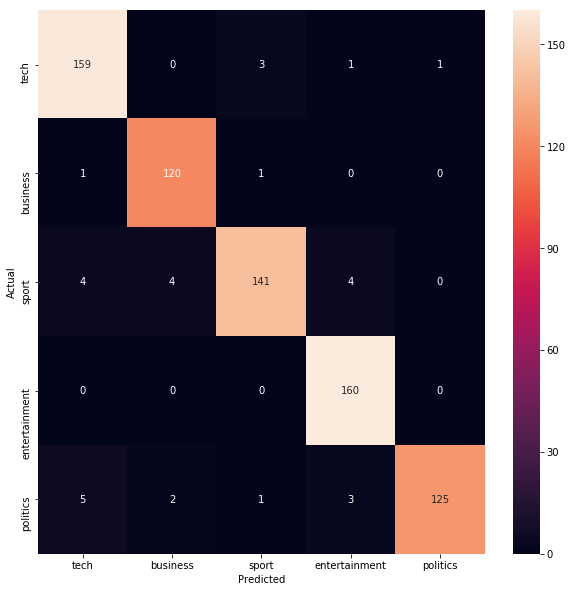

In [20]:
count_conf_mat = confusion_matrix(y_test, count_preds)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(count_conf_mat, annot=True, fmt='d',
            xticklabels=bbc_articles['category'].unique(), yticklabels=bbc_articles['category'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [21]:
tfidf_transform = tfidf_pipe.fit(X_train, y_train)
tfidf_preds = tfidf_pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, tfidf_preds))

Accuracy: 0.9727891156462585


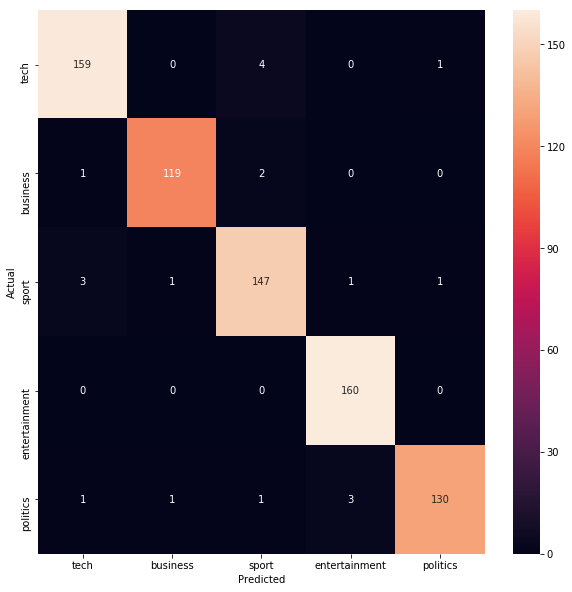

In [22]:
tfidf_conf_mat = confusion_matrix(y_test, tfidf_preds)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(tfidf_conf_mat, annot=True, fmt='d',
            xticklabels=bbc_articles['category'].unique(), yticklabels=bbc_articles['category'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

##### POS

In [23]:
nlp = spacy.load('en_core_web_sm')

In [24]:
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')
for token in doc:
    print("{", token.text, "-->: ", token.lemma_, "}", token.pos_, token.tag_, token.dep_,
          token.shape_, token.is_alpha, token.is_stop)

{ Apple -->:  apple } PROPN NNP nsubj Xxxxx True False
{ is -->:  be } VERB VBZ aux xx True True
{ looking -->:  look } VERB VBG ROOT xxxx True False
{ at -->:  at } ADP IN prep xx True True
{ buying -->:  buy } VERB VBG pcomp xxxx True False
{ U.K. -->:  u.k. } PROPN NNP compound X.X. False False
{ startup -->:  startup } NOUN NN dobj xxxx True False
{ for -->:  for } ADP IN prep xxx True True
{ $ -->:  $ } SYM $ quantmod $ False False
{ 1 -->:  1 } NUM CD compound d False False
{ billion -->:  billion } NUM CD pobj xxxx True False


In [25]:
doc = nlp(bbc_articles.loc[0]['text'])
for token in doc:
    print("{", token.text, "-->: ", token.lemma_, "}", token.pos_, token.tag_, token.dep_,
          token.shape_, token.is_alpha, token.is_stop)

{ tv -->:  tv } NOUN NN compound xx True False
{ future -->:  future } NOUN NN nsubj xxxx True False
{ in -->:  in } ADP IN prep xx True True
{ the -->:  the } DET DT det xxx True True
{ hands -->:  hand } NOUN NNS pobj xxxx True False
{ of -->:  of } ADP IN prep xx True True
{ viewers -->:  viewer } NOUN NNS pobj xxxx True False
{ with -->:  with } ADP IN prep xxxx True True
{ home -->:  home } NOUN NN compound xxxx True False
{ theatre -->:  theatre } NOUN NN compound xxxx True False
{ systems -->:  system } NOUN NNS nmod xxxx True False
{   -->:    } SPACE     False False
{ plasma -->:  plasma } NOUN NN compound xxxx True False
{ high -->:  high } ADJ JJ amod xxxx True False
{ - -->:  - } PUNCT HYPH punct - False False
{ definition -->:  definition } NOUN NN nmod xxxx True False
{ tvs -->:  tvs } NOUN NN nmod xxx True False
{   -->:    } SPACE     False False
{ and -->:  and } CCONJ CC cc xxx True True
{ digital -->:  digital } ADJ JJ conj xxxx True False
{ video -->:  video } NOUN 

{ in -->:  in } PART RP prep xx True True
{ to -->:  to } ADP IN prep xx True True
{ high -->:  high } ADJ JJ amod xxxx True False
{ - -->:  - } PUNCT HYPH punct - False False
{ definition -->:  definition } NOUN NN compound xxxx True False
{ tv -->:  tv } NOUN NN nsubj xx True False
{ sets -->:  set } NOUN NNS pobj xxxx True False
{   -->:    } SPACE     False False
{ which -->:  which } ADJ WDT nsubj xxxx True True
{ are -->:  be } VERB VBP advcl xxx True True
{ big -->:  big } ADJ JJ amod xxx True False
{ business -->:  business } NOUN NN attr xxxx True False
{ in -->:  in } ADP IN prep xx True True
{ japan -->:  japan } NOUN NN pobj xxxx True False
{ and -->:  and } CCONJ CC cc xxx True True
{ the -->:  the } DET DT det xxx True True
{ us -->:  -PRON- } PRON PRP conj xx True True
{   -->:    } SPACE     False False
{ but -->:  but } CCONJ CC cc xxx True True
{ slower -->:  slow } ADJ JJR conj xxxx True False
{ to -->:  to } PART TO aux xx True True
{ take -->:  take } VERB VB relcl

{ moment -->:  moment } NOUN NN pobj xxxx True False
{ for -->:  for } ADP IN prep xxx True True
{ commercial -->:  commercial } ADJ JJ amod xxxx True False
{ uk -->:  uk } ADJ JJ intj xx True False
{ broadcasters -->:  broadcaster } NOUN NNS pobj xxxx True False
{   -->:    } SPACE     False False
{ but -->:  but } CCONJ CC cc xxx True True
{ brand -->:  brand } NOUN NN compound xxxx True False
{ loyalty -->:  loyalty } NOUN NN nsubj xxxx True False
{ is -->:  be } VERB VBZ conj xx True True
{ important -->:  important } ADJ JJ acomp xxxx True False
{ for -->:  for } ADP IN prep xxx True True
{ everyone -->:  everyone } NOUN NN pobj xxxx True True
{ . -->:  . } PUNCT . punct . False False
{   -->:    } SPACE     False False
{ we -->:  -PRON- } PRON PRP nsubj xx True True
{ will -->:  will } VERB MD aux xxxx True True
{ be -->:  be } VERB VB aux xx True True
{ talking -->:  talk } VERB VBG ROOT xxxx True False
{ more -->:  more } ADV RBR advmod xxxx True True
{ about -->:  about } ADP 

{ are -->:  be } VERB VBP aux xxx True True
{ getting -->:  get } VERB VBG ccomp xxxx True False
{ . -->:  . } PUNCT . punct . False False
{ they -->:  -PRON- } PRON PRP nsubj xxxx True True
{ perhaps -->:  perhaps } ADV RB advmod xxxx True True
{ do -->:  do } VERB VBP aux xx True True
{ not -->:  not } ADV RB neg xxx True True
{ want -->:  want } VERB VB ccomp xxxx True False
{ so -->:  so } ADV RB advmod xx True True
{ much -->:  much } ADJ JJ dobj xxxx True True
{ of -->:  of } ADP IN prep xx True True
{ the -->:  the } DET DT det xxx True True
{ choice -->:  choice } NOUN NN pobj xxxx True False
{ put -->:  put } VERB VBN acl xxx True True
{ into -->:  into } ADP IN prep xxxx True True
{ their -->:  -PRON- } ADJ PRP$ poss xxxx True True
{ hands -->:  hand } NOUN NNS pobj xxxx True False
{   -->:    } SPACE     False False
{ mr -->:  mr } ADP IN compound xx True False
{ hanlon -->:  hanlon } NOUN NN nsubj xxxx True False
{ suggested -->:  suggest } VERB VBD ROOT xxxx True False
{ .

{ windows -->:  window } NOUN NNS nmod xxxx True False
{ pcs -->:  pcs } NOUN NN pobj xxx True False
{ and -->:  and } CCONJ CC cc xxx True True
{ mobile -->:  mobile } ADJ JJ amod xxxx True False
{ devices -->:  device } NOUN NNS conj xxxx True False
{ . -->:  . } PUNCT . punct . False False
{ all -->:  all } ADJ PDT predet xxx True True
{ these -->:  these } DET DT nsubj xxxx True True
{ reflect -->:  reflect } VERB VBP ROOT xxxx True False
{ the -->:  the } DET DT det xxx True True
{ increasing -->:  increase } VERB VBG amod xxxx True False
{ trend -->:  trend } NOUN NN dobj xxxx True False
{ of -->:  of } ADP IN prep xx True True
{ freeing -->:  free } VERB VBG pcomp xxxx True False
{ up -->:  up } PART RP prt xx True True
{ multimedia -->:  multimedia } NOUN NN dobj xxxx True False
{ so -->:  so } ADP IN mark xx True True
{ that -->:  that } ADP IN mark xxxx True True
{ people -->:  people } NOUN NNS nsubj xxxx True False
{ can -->:  can } VERB MD aux xxx True True
{ watch -->:  w

##### NER

In [26]:
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [27]:
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')
# doc = nlp('European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices')
print([(X.text, X.label_) for X in doc.ents])

[('Apple', 'ORG'), ('U.K.', 'GPE'), ('$1 billion', 'MONEY')]


In [28]:
doc = nlp(bbc_articles.loc[0]['text'])
print([(X.text, X.label_) for X in doc.ents])

[('five years  time', 'DATE'), ('annual', 'DATE'), ('one', 'CARDINAL'), (' ', 'NORP'), (' ', 'NORP'), (' ', 'NORP'), ('one', 'CARDINAL'), (' ', 'NORP'), (' ', 'NORP'), (' ', 'NORP'), (' ', 'NORP'), (' ', 'NORP'), ('japan', 'GPE'), (' ', 'NORP'), (' ', 'NORP'), (' ', 'NORP'), (' ', 'NORP'), ('today', 'DATE'), (' ', 'NORP'), ('nine months to a years', 'DATE'), (' ', 'NORP'), ('  ', 'ORG'), ('  ', 'ORG'), (' ', 'ORG'), (' ', 'NORP'), (' ', 'ORG'), (' ', 'NORP'), (' ', 'NORP'), (' ', 'NORP'), (' ', 'NORP'), (' ', 'NORP'), ('  ', 'ORG'), (' ', 'ORG'), (' ', 'NORP'), ('50 000', 'CARDINAL'), ('one', 'CARDINAL'), ('80-hour', 'CARDINAL'), ('one', 'CARDINAL'), (' ', 'NORP'), (' ', 'ORG'), ('100-hours', 'CARDINAL'), (' ', 'NORP'), (' ', 'PERSON'), ('up to 90 hours', 'TIME')]


##### Topic Modelling

In [29]:
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [30]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ardidandeh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ardidandeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [33]:
bbc_articles = pd.read_csv("data/bbc-text.csv")

In [34]:
import random
text_data = []
for article in bbc_articles['text']:
    tokens = prepare_text_for_lda(article)
    if random.random() > .99:
        text_data.append(tokens)

In [35]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
import pickle
pickle.dump(corpus, open('models/corpus.pkl', 'wb'))
dictionary.save('models/dictionary.gensim')

In [36]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('models/model5.gensim')
topics = ldamodel.print_topics(num_words=4)

In [37]:
for topic in topics:
    print(topic)
    print("------------------------------------------------------------------------------------------")

(0, '0.009*"nuclear" + 0.005*"spacey" + 0.005*"darin" + 0.005*"technology"')
------------------------------------------------------------------------------------------
(1, '0.011*"foster" + 0.011*"carers" + 0.011*"found" + 0.009*"security"')
------------------------------------------------------------------------------------------
(2, '0.012*"ireland" + 0.008*"union" + 0.008*"penalty" + 0.008*"bollywood"')
------------------------------------------------------------------------------------------
(3, '0.017*"india" + 0.015*"attack" + 0.013*"mobile" + 0.008*"market"')
------------------------------------------------------------------------------------------
(4, '0.009*"coach" + 0.009*"virtual" + 0.008*"gamers" + 0.008*"entropia"')
------------------------------------------------------------------------------------------


In [38]:
dictionary = gensim.corpora.Dictionary.load('models/dictionary.gensim')
corpus = pickle.load(open('models/corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('models/model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


More reading for future:

https://nlpoverview.com
https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/